In [36]:
import cv2
import matplotlib.pyplot as plt
from preprocess_images import apply_circular_mask, process_for_stopping_criteria
import numpy as np
from skimage.metrics import structural_similarity as ssim
import skimage

In [37]:
def to_square(img, t_x, t_y, b_x, b_y):
    h, w = img.shape[:2]
    m_x = w//2 + b_x
    m_y = h//2 + b_y
    return img[m_y-t_y//2:m_y+t_y//2,m_x-t_x//2:m_x+t_x//2]  

def high_pass(img, t):
    new = np.copy(img)
    new[img<t] = 0
    return new

# Histogram Equalization

In [38]:
dark_path = "/mnt/h/latest_real_data/real_data/real/x0.00_y0.00.jpg"
lamp_path = "/mnt/h/latest_real_data/light/x0.00_y0.00.jpg"
light_path = "/mnt/h/newlight/main_light/x0.00_y0.00.jpg"

dark = cv2.imread(dark_path, cv2.IMREAD_GRAYSCALE)
lamp = cv2.imread(lamp_path, cv2.IMREAD_GRAYSCALE)
light = cv2.imread(light_path, cv2.IMREAD_GRAYSCALE)

Original


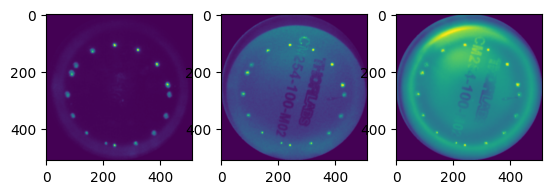

In [39]:
fig, axes = plt.subplots(1,3)
print("Original")
axes[0].imshow(dark)
axes[1].imshow(lamp)
axes[2].imshow(light)
plt.show()

equalizeHist


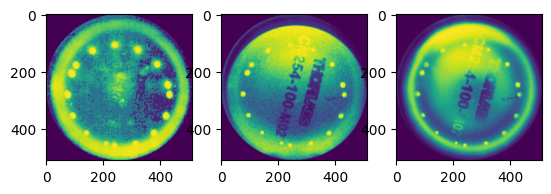

In [40]:
eqdark = cv2.equalizeHist(np.copy(dark))
eqlamp = cv2.equalizeHist(np.copy(lamp))
eqlight = cv2.equalizeHist(np.copy(light))

fig, axes = plt.subplots(1,3)
print("equalizeHist")
axes[0].imshow(eqdark)
axes[1].imshow(eqlamp)
axes[2].imshow(eqlight)
plt.show()

CLAHE


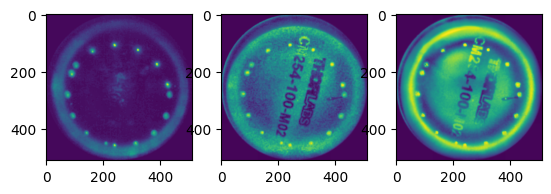

In [41]:
clahe = cv2.createCLAHE(clipLimit=5)
aeqdark = clahe.apply(np.copy(dark))
aeqlamp = clahe.apply(np.copy(lamp))
aeqlight = clahe.apply(np.copy(light))

fig, axes = plt.subplots(1,3)
print("CLAHE")
axes[0].imshow(aeqdark)
axes[1].imshow(aeqlamp)
axes[2].imshow(aeqlight)
plt.show()

In [62]:
def grad(gray):
    gray = cv2.GaussianBlur(gray, (7,7), 3)
    gX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    gY = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)
    # the gradient magnitude images are now of the floating point data
    # type, so we need to take care to convert them back a to unsigned
    # 8-bit integer representation so other OpenCV functions can operate
    # on them and visualize them
    gX = cv2.convertScaleAbs(gX)
    gY = cv2.convertScaleAbs(gY)
    # combine the gradient representations into a single image
    return cv2.addWeighted(gX, 0.5, gY, 0.5, 0)

grad


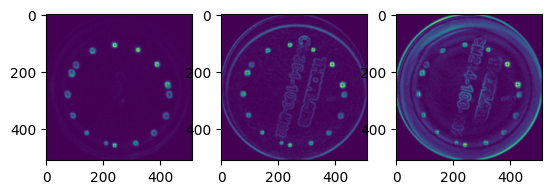

In [63]:
grad_dark = grad(np.copy(dark))
grad_lamp = grad(np.copy(lamp))
grad_light = grad(np.copy(light))

fig, axes = plt.subplots(1,3)
print("grad")
axes[0].imshow(grad_dark)
axes[1].imshow(grad_lamp)
axes[2].imshow(grad_light)
plt.show()

hp


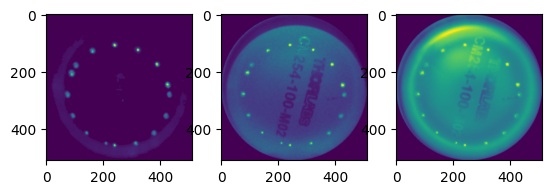

In [64]:
t = 10
hp_dark = np.copy(dark)
hp_lamp = np.copy(lamp)
hp_light = np.copy(light)
hp_dark[hp_dark<t] = 0
hp_lamp[hp_lamp<t] = 0
hp_light[hp_light<t] = 0

fig, axes = plt.subplots(1,3)
print("hp")
axes[0].imshow(hp_dark)
axes[1].imshow(hp_lamp)
axes[2].imshow(hp_light)
plt.show()

hpgrad


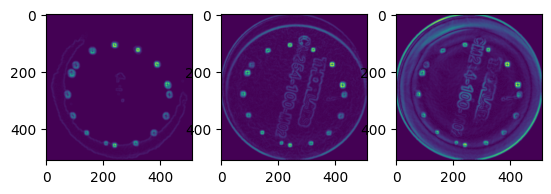

In [65]:
hpgrad_dark = grad(np.copy(hp_dark))
hpgrad_lamp = grad(np.copy(hp_lamp))
hpgrad_light = grad(np.copy(hp_light))

fig, axes = plt.subplots(1,3)
print("hpgrad")
axes[0].imshow(hpgrad_dark)
axes[1].imshow(hpgrad_lamp)
axes[2].imshow(hpgrad_light)
plt.show()

# Stopping criteria

(512, 512)


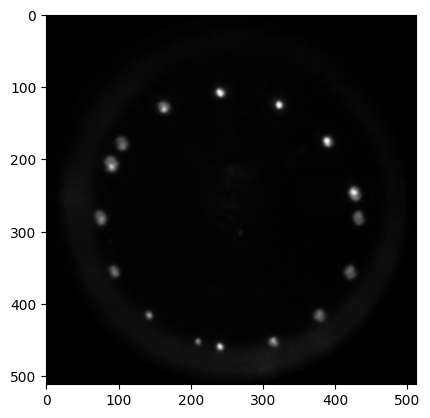

In [45]:
data_folder = "/mnt/h/latest_real_data/real_data/real"
opt_fname = "x0.00_y0.00.jpg"
img_fname = "x0.20_y0.30.jpg"
HT = 0
opt_img = cv2.imread(data_folder+"/"+opt_fname, cv2.IMREAD_GRAYSCALE)
print(opt_img.shape)
plt.imshow(opt_img, cmap="gray")

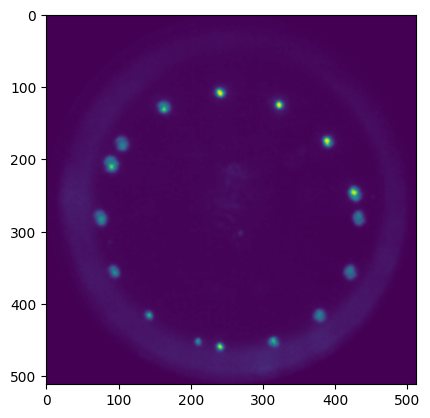

In [46]:
opt_processed = process_for_stopping_criteria(opt_img, HT)
plt.imshow(opt_processed)
plt.show()

In [47]:
def distance_from_optimum(optimum, img) -> float:
    diff = optimum - img
    diff = np.abs(diff)

    return np.sum(diff)/255

def structural_diff(optimum, img) -> float:
    return ssim(optimum, img)

In [48]:
test_img = cv2.imread(data_folder+"/"+img_fname, cv2.IMREAD_GRAYSCALE)
test_img = process_for_stopping_criteria(test_img, ht=HT)
print(distance_from_optimum(opt_img, test_img))

86628.64705882352


In [49]:
# Prepare images and x,y values

xi = -1.99
xmax = 3.69
yi = -1.99
ymax = 1.99

step = 0.2

x_vals = []
while xi < xmax:
    x_vals.append(xi)
    xi += step
    xi = round(xi, 2)

y_vals = []
while yi < ymax:
    y_vals.append(yi)
    yi += step
    yi = round(yi, 2)

fnames = [(x,y,f"x{x:.2f}_y{y:.2f}.jpg") for x in x_vals for y in y_vals]
print(len(fnames))
print(fnames[:5])



580
[(-1.99, -1.99, 'x-1.99_y-1.99.jpg'), (-1.99, -1.79, 'x-1.99_y-1.79.jpg'), (-1.99, -1.59, 'x-1.99_y-1.59.jpg'), (-1.99, -1.39, 'x-1.99_y-1.39.jpg'), (-1.99, -1.19, 'x-1.99_y-1.19.jpg')]


In [50]:
# Collect distances
def evaluate(fnames, diff_func):
    i = 0
    results = np.zeros((len(fnames), 3))
    for x, y, fname in fnames:
        # Load img
        img = cv2.imread(data_folder+"/"+fname, cv2.IMREAD_GRAYSCALE)

        # Add noize
        # img = skimage.util.random_noise(img, mode='gaussian')

        # Preprocess
        # img = process_for_stopping_criteria(img, ht=HT)

        # Calc diff
        d = diff_func(opt_img, img)

        # Rec
        results[i,0] = x
        results[i,1] = y
        results[i,2] = d

        i+= 1
    return results

In [51]:
results = evaluate(fnames, structural_diff)


KeyboardInterrupt: 

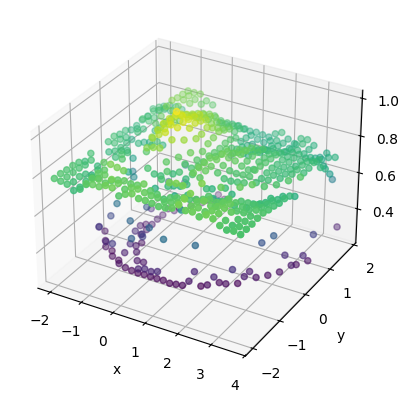

In [ ]:
# display

fig = plt.figure()
ax = plt.subplot(111, projection='3d')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(results[:,0], results[:,1], results[:,2], c=results[:,2], cmap='viridis')
plt.show()

In [ ]:
xzero = np.argmin(np.abs(results[:,0]))
yzero = np.argmin(np.abs(results[xzero:xzero+50,1]))
yzero += xzero
print(xzero, yzero)
print(results[yzero])

200 210
[0.01       0.01       0.98978874]


In [ ]:
a = np.argmax(results[:,2])
print(a)
print(results[a])

210
[0.01       0.01       0.98978874]
